##**TPS10- Gaussian Variational Bayes**
###Baltazar Ariel Etchepareborda, Padron: 109537
Solo se puede usar numpy, matplotlib.pyplot,gamma digamma softmax de scipy.special

###Importaciones iniciales
Hago todos los imports de lo que puedo usar ahora una vez

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma,digamma,softmax

###Problema
Se quiere modelar el tiempo en minutos con respecto a la hora de entrada en que difernetes grupos de estudiantes llegan a la clase del a facultad, Se modela como mezcla de 6 comportamientos de personas.

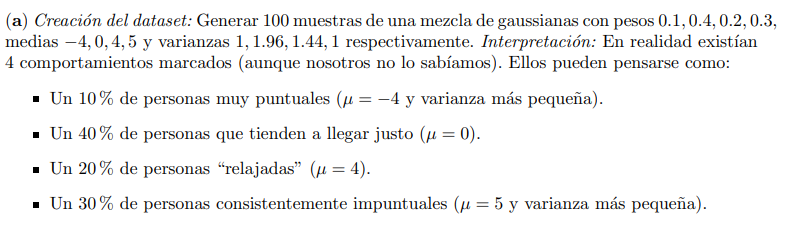

Mezcla de Gaussianas:


Tengo una media que define su centro


Una covarianza


Una probabilidad de mezcla que define que tan grande o chica va a ser la funcion gaussiana

 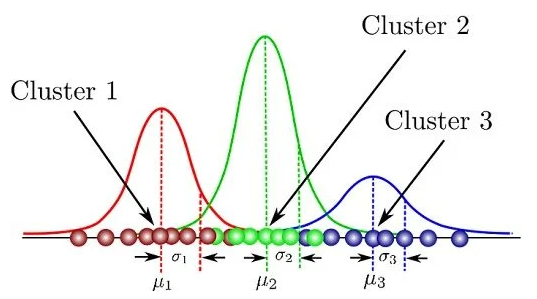

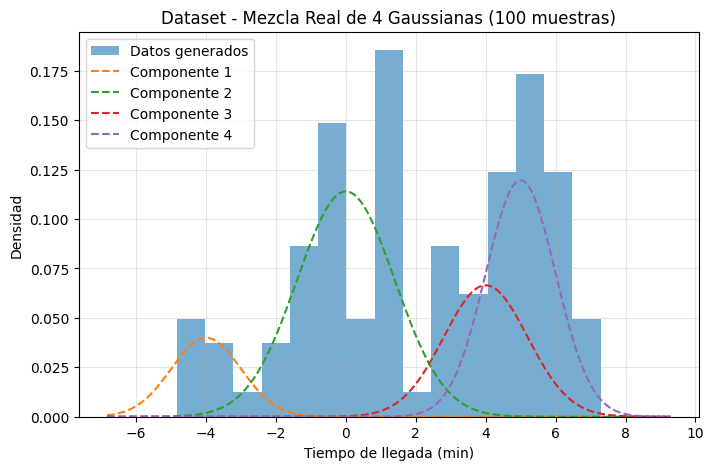

Primeras 10 muestras generadas:
[-0.569 -1.583  5.909 -4.642  0.954  2.493  4.316  6.935  5.248  2.047]


In [50]:
# Parámetros verdaderos (4 componentes reales)
pesos = np.array([0.1, 0.4, 0.2, 0.3])
medias = np.array([-4.0, 0.0, 4.0, 5.0])
varianzas = np.array([1.0, 1.96, 1.44, 1.0])
sigma = np.sqrt(varianzas)
N = 100
##Elijo con probabilidad peso de cada una de las clases
componentes = np.random.choice(4, size=N, p=pesos)
# Genero los datos
x = np.zeros(N)
for k in range(4):
    idx = (componentes == k)
    x[idx] = np.random.normal(loc=medias[k], scale=sigma[k], size=idx.sum())

#Grafico
xmin, xmax = x.min() - 2, x.max() + 2
xs = np.linspace(xmin, xmax, 300)

def gaussian_pdf(z, mu, sigma2):
    return (1/np.sqrt(2*np.pi*sigma2)) * np.exp(-(z-mu)**2/(2*sigma2))

plt.figure(figsize=(8,5))
plt.hist(x, bins=15, density=True, alpha=0.6, label="Datos generados")

#Multiplico la normal generada por separado por su probabilidad(peso en la mezcla) para que siga integrando la conjunta...
for k in range(4):
    plt.plot(xs, pesos[k] * gaussian_pdf(xs, medias[k], varianzas[k]),
             '--', label=f"Componente {k+1}")

plt.title("Dataset - Mezcla Real de 4 Gaussianas (100 muestras)")
plt.xlabel("Tiempo de llegada (min)")
plt.ylabel("Densidad")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("Primeras 10 muestras generadas:")
print(np.round(x[:10], 3))


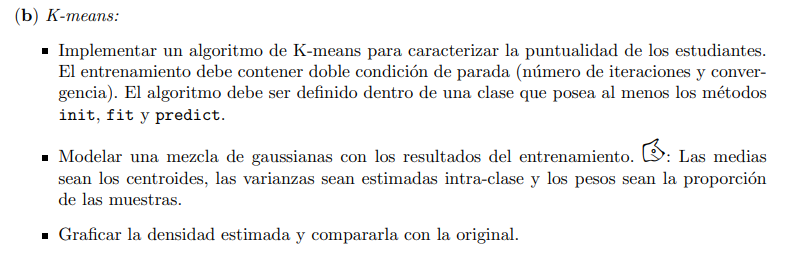

Como lo tengo hecho del TPS7, lo traigo aca y lo modifico.

El algoritmo de K Means funciona de la siguiente manera.
Como input se toma X y K.

X es una matriz de datos de n muestras x d dimensiones y K es el numero de de clusters (que se define antes al modelar el problema).


Se inicializa $\mu$ (centroide del cluster) con el valor de K columnas de X elegidas al azar.
despues, se computa el $y[i]$ como la minima clase k de la distancia entre la tira de datos para la imagen i y todos los centroides.
Despues, el centroide se recalcula como la esperanza de que los datos asumiendo que la clase es k hasta llegar a la convergencia (o en este TP hasta una cierta cantidad de iteraciones tambien).


In [51]:
class KMeans:
    def __init__(self, K, max_iter=100, tol=1e-4):
        self.K = K #Guardo la cantidad de clases
        self.max_iter = max_iter #Especificacion que me pidieron de enunciado.
        self.tol = tol  #Como me pidieron que tenga doble criterio de termiacion
        self.centroids = None

    def fit(self, X):
        X = X.reshape(-1,1)

        # Primero empiezo con los centroides inicializados al azar.
        indices = np.random.choice(X.shape[0], self.K, replace=False)
        self.centroids = X[indices].copy()
        #Repito hasta alcanzar la cantidad de iteraciones (adentro tengo un break para cuando converge)
        for it in range(self.max_iter):
            old_centroids = self.centroids.copy()

            # Calculo la distancia de la tira de datos contra los centroides que tengo de antes.
            dists = np.abs(X - self.centroids.T)   # dist 1D
            labels = np.argmin(dists, axis=1) #Guardo el y al que pertenecerian

            # Actualización
            for k in range(self.K):
                points = X[labels == k] #Asigno todos los puntos a los centroides
                if len(points) > 0:
                    self.centroids[k] = points.mean() #Actualizo el centroide como la media de todos los puntos correspondientes a la clase K.

            # Me fijo si converge.
            shift = np.abs(self.centroids - old_centroids).max()
            if shift < self.tol:
                print(f"Convergió en {it+1} iteraciones")
                break

        self.labels_ = labels
        return self
    #El predict en Kmeans es directamente ver a cual de los centroides una muestra en testeo esta mas cerca
    def predict(self, X):
        X = X.reshape(-1,1)
        dists = np.abs(X - self.centroids.T)
        return np.argmin(dists, axis=1)


Convergió en 13 iteraciones
Centroides encontrados:
[-2.98982648  6.98494688  0.33334564  4.55502887  2.98028462  5.61662819]


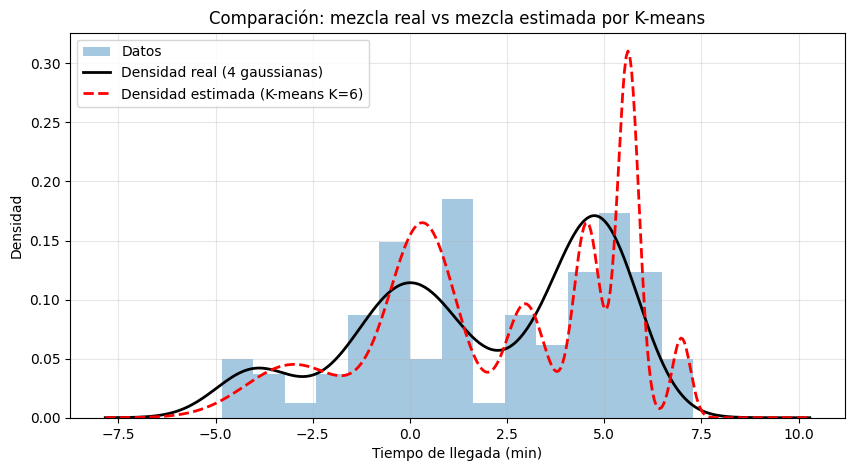

Pesos estimados: [0.14 0.04 0.35 0.14 0.12 0.21]
Varianzas estimadas: [1.53567718 0.05591998 0.72620785 0.11513862 0.25320989 0.07344724]


In [52]:
# Entreno
K = 6  ###Esto esta raro, pero bueno, si piide que vaya con 6, entiendo van a dar mal k means y EM...
kmeans = KMeans(K=K, max_iter=200, tol=1e-4)
kmeans.fit(x)

labels = kmeans.labels_
centroids = kmeans.centroids.flatten()

print("Centroides encontrados:")
print(centroids)

#Modelo la mezcla con kmeans, esto lo dice el enunciado
# pesos = proporciones, medias = centroides, varianzas = intra-cluster

#Inicializo
pesos_k = np.zeros(K)
var_k = np.zeros(K)

for k in range(K):
    pts = x[labels == k] #Los puntos para un centroide son los que matchean el label.
    pesos_k[k] = len(pts) / len(x) #frecuencia relativa para una clase k
    if len(pts) > 1:
        var_k[k] = pts.var()
    else:
        var_k[k] = 1.0  # fallback si un cluster queda con un solo punto
#Le hago la pdf.
def gaussian_pdf(z, mu, sigma2):
    return (1/np.sqrt(2*np.pi*sigma2)) * np.exp(-(z-mu)**2/(2*sigma2))

xmin, xmax = x.min() - 3, x.max() + 3
xs = np.linspace(xmin, xmax, 400)

# densidad original
pesos_orig = np.array([0.1, 0.4, 0.2, 0.3])
medias_orig = np.array([-4.0, 0.0, 4.0, 5.0])
vars_orig = np.array([1.0, 1.96, 1.44, 1.0])

p_real = np.zeros_like(xs)
for j in range(4):
    p_real += pesos_orig[j] * gaussian_pdf(xs, medias_orig[j], vars_orig[j])

# densidad estimada por K-means
p_est = np.zeros_like(xs)
for j in range(K):
    p_est += pesos_k[j] * gaussian_pdf(xs, centroids[j], var_k[j])

# ----------------------------------------------------------
# Gráfico comparativo
# ----------------------------------------------------------

plt.figure(figsize=(10,5))
plt.hist(x, bins=15, density=True, alpha=0.4, label="Datos")

plt.plot(xs, p_real, 'k-', linewidth=2, label="Densidad real (4 gaussianas)")
plt.plot(xs, p_est, 'r--', linewidth=2, label=f"Densidad estimada (K-means K={K})")

plt.title("Comparación: mezcla real vs mezcla estimada por K-means")
plt.xlabel("Tiempo de llegada (min)")
plt.ylabel("Densidad")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

print("Pesos estimados:", pesos_k)
print("Varianzas estimadas:", var_k)


El modelado con K means tiene sentido que no de del todo bien, no modela covarianzas diferentes por clase, ademas, al pensar que la distribucion subyacente de los datos se representa por 6 centroides, no se calculan bien.

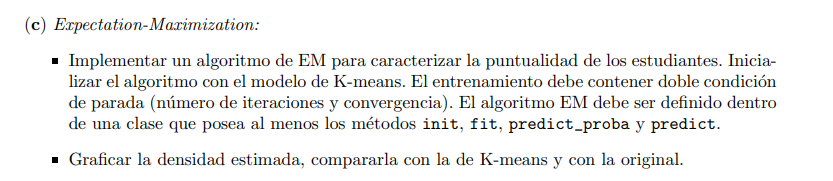

##**Como funciona el algoritmo EM? - Resumen para explicar y tambien para mi**


Cuando no sabemos algun parametro del proceso que genero los datos, y tampoco sabemos alguno de los puntos para ir haciendo el paso E y el paso M asumiendo alguno de los dos desconocidos y computando el otro.


Se define la probabilidad de un valor de un punto x dado que tneemos un estimador $\mu$ que asumimos antes. Porque dije que esa iba a ser la distribucion subyacente de los datos.


Se define la likelihood para un dado valor parametro $\mu$ o $\theta$ cual es la probabilidad de haber visto un dato efectivamente en el mundo real.


Como son independientes cada una de las tiradas, se puede multiplicar cada una de los datos por separado dado que dijimos que el estimador es $\mu$ supuesto conocido. Para la likelihood nosotros dijimos que iba a ser ese mismo. Por temas computacioanles le calculo el logaritmo antes asi es mas sencillo sumarlas despues.. (conveniencia).


Algoritmo:


Inicializacion, adivino algun valor de $\mu$, quizas promedio de los puntos que si tengo.


Expectation - E Step.  


Se hace la expected log likelihood. es funcion de $\mu$, descubrir si mi estimador en este paso, cual es el mejor update del parametro en la siguiente. Es una funcion de la proposed next $\mu$. Es la integral sobre todos los valores de $X$ (de los valores que no tenemos todavia), escaneamos sobre todos los valores de $X$ porque no sabemos que es $X$. Dentro de la integral, para cada valor de X estamos computando la probabilidad del $\mu$ que estamos generando en el paso anterior $\mu_0$, asumiendo que esta bien la distribucion generada a partir de $\mu_0$, cual es la probabilidad de haber generado ese $X$ que hicimos antes. Este termino actua como un peso, despues viene la log likelihood de ver esa coleccion de puntos dado que conocemos $\mu$ (el siguiente mu despues de $\mu_0$.


Es una weighted sum donde el weight es la probabilidad de que el valor para este valor faltante este correcto y el valor es la log likelihood de ver esos datos dado que el $\mu$ que me genero los datos es efectivamente el que estoy prediciendo $E(LL|U)$.


El primer termino esta poniendo en juego los valores que no conozco a partir de lo que yo tengo ahora, y el segundo termino estoy diciendo que me tiene que importar de la proposed log likelihood para cada uno de los missing points que tienen una alta probabilidad ahora.



Maximization - M Step

Dame el $\mu$ que maximiza esta funcion de expected log likelihood me va a dar en promedio la mayor log likelihood para los valores de X que son mas probables.


Se vuelve a empezar, se guarda el $\mu$ anterior $\mu_0, \mu_1, \mu_2$ y asi siguiendo hasta que converja. Cuando yo tengo un buen parametro de $\mu$, ahora si en la parte de $X$ desconocido (test), ahora si cuando conozco los otros datos, y la caracteristica de la a posteriori, puedo predecir cual va a ser el valor del dato que faltaba.


En clustering se usa para decir tengo clases con sus propias gaussianas con propia media y std dev, no se los $\mu,\sigma, X_{K==k}$


hasta la convergencia.


Por que convergeria?


Se puede demostrar que despues de hacer un paso E y M estoy en un lugar mejor que antes para la funcion de log likelihood (al menos localmente).

EM convergió en 65 iteraciones


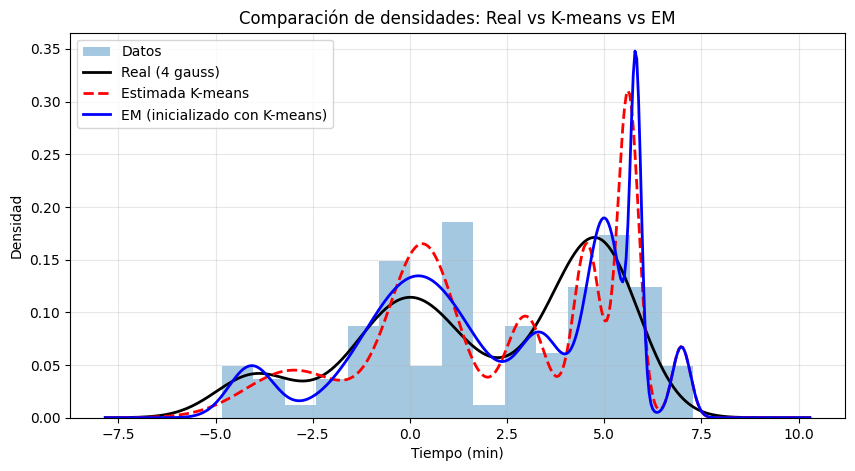


Parámetros aprendidos por EM:
Pesos = [0.07003344 0.03980544 0.46361546 0.22138535 0.09954761 0.1056127 ]
Medias = [-4.08217158  6.98651613  0.2183535   5.00530861  3.381857    5.81483696]
Varianzas = [0.33322326 0.05569137 1.88779771 0.21995729 0.31292393 0.01898335]


In [53]:
class EM:
    def __init__(self, K, max_iter=200, tol=1e-5):
        self.K = K
        self.max_iter = max_iter
        self.tol = tol

    def gaussian_pdf(self, x, mu, sigma2):
        return (1/np.sqrt(2*np.pi*sigma2)) * np.exp(-(x-mu)**2/(2*sigma2))

    # ------------------------------------------
    def fit(self, X, mu_init, var_init, pi_init):
        X = X.reshape(-1)
        N = len(X)

        # inicializo desde el k means
        self.mu = mu_init.copy()
        self.var = var_init.copy()
        self.pi = pi_init.copy()

        log_likelihood_old = -np.inf

        for it in range(self.max_iter):

            ##Expectation
            r = np.zeros((N, self.K))
            for k in range(self.K): #Para cada cluster
                r[:, k] = self.pi[k] * self.gaussian_pdf(X, self.mu[k], self.var[k]) #le hago q(k|x) = p(k|x,tita) en el apunte. Mi estimador en este paso es el que ya tnego armado
                ###Con mis mu y mi varianza antes armada, entonces es directamente sacar el peso de mi clase, con mis muestras y mis parametros al momento
            # normalización
            r = r / r.sum(axis=1, keepdims=True) #Como es una probabilidad normalizo.

            Nk = r.sum(axis=0) #Guardo la cantidad por clase para despues calcular la actualziacion de la media y de la covarianza por clase(en la diapo de matias)

            # Maximization
            #El paso de maximizacion es sacar con la distribucion que acabo de conseguir recalcular los parametros con los que estoy iterando.
            #mi r va a ser q(k|xi)
            for k in range(self.K):
                # media
                self.mu[k] = (r[:, k] @ X) / Nk[k]

                # varianza
                diff = X - self.mu[k]
                self.var[k] = (r[:, k] @ (diff**2)) / Nk[k]

            # pesos
            self.pi = Nk / N

            #Uso el criterio de log likelihood para ver cuando parar.
            ll = 0
            for k in range(self.K):
                ll += self.pi[k] * self.gaussian_pdf(X, self.mu[k], self.var[k])
            ll = np.sum(np.log(ll + 1e-12))   # estabilidad numérica

            # criterio de parada
            if np.abs(ll - log_likelihood_old) < self.tol:
                print(f"EM convergió en {it+1} iteraciones")
                break

            log_likelihood_old = ll

        return self

    # ------------------------------------------
    #Esto es la probabilidad de una tira de datos X a una clase k, para esto no lo uso porque el problema se basa en calcular las pdfs, el predict es como siempre el argmax.
    def predict_proba(self, X):
        X = X.reshape(-1)
        N = len(X)

        r = np.zeros((N, self.K))
        for k in range(self.K):
            r[:, k] = self.pi[k] * self.gaussian_pdf(X, self.mu[k], self.var[k])

        return r / r.sum(axis=1, keepdims=True)

    # ------------------------------------------
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


# ----------------------------------------------------------
# ENTRENAMIENTO EM USANDO INICIALIZACIÓN DE K-MEANS
# ----------------------------------------------------------

em = EM(K=6, max_iter=200, tol=1e-5)
em.fit(x, centroids, var_k, pesos_k)


# ----------------------------------------------------------
# DENSIDADES PARA GRAFICAR
# ----------------------------------------------------------

xmin, xmax = x.min() - 3, x.max() + 3
xs = np.linspace(xmin, xmax, 400)

def pdf_mix(xs, pi, mu, var):
    p = np.zeros_like(xs)
    for j in range(len(pi)):
        p += pi[j] * (1/np.sqrt(2*np.pi*var[j])) * np.exp(-(xs-mu[j])**2/(2*var[j]))
    return p

# mezcla verdadera
p_real = pdf_mix(xs, pesos_orig, medias_orig, vars_orig)

# mezcla estimada K-means
p_kmeans = pdf_mix(xs, pesos_k, centroids, var_k)

# mezcla EM
p_em = pdf_mix(xs, em.pi, em.mu, em.var)


# ----------------------------------------------------------
# GRÁFICO COMPARATIVO
# ----------------------------------------------------------

plt.figure(figsize=(10,5))
plt.hist(x, bins=15, density=True, alpha=0.4, label="Datos")

plt.plot(xs, p_real, 'k-', linewidth=2, label="Real (4 gauss)")
plt.plot(xs, p_kmeans, 'r--', linewidth=2, label="Estimada K-means")
plt.plot(xs, p_em, 'b-', linewidth=2, label="EM (inicializado con K-means)")

plt.title("Comparación de densidades: Real vs K-means vs EM")
plt.xlabel("Tiempo (min)")
plt.ylabel("Densidad")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

print("\nParámetros aprendidos por EM:")
print("Pesos =", em.pi)
print("Medias =", em.mu)
print("Varianzas =", em.var)


La forma general del EM no funciona bien porque de nuevo se esta modelando con mas cantidad de cluster que la que describe la distribucion subyacente de los datos, hay algunos centroides que tienen muy baja varianza (de ahi los picos por muy pocas muestras).




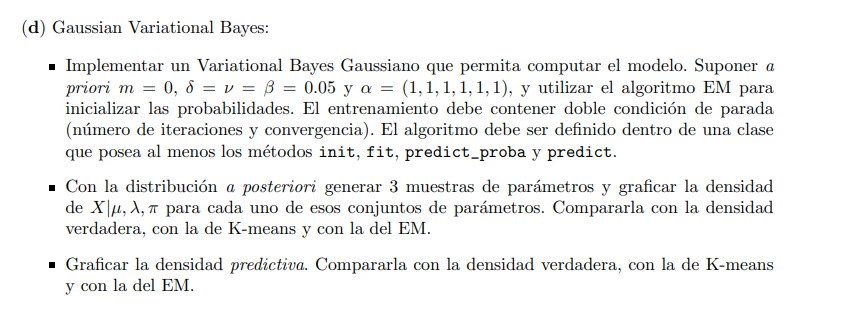

##**Gaussian Variational Bayes**

###Necestiaba un poco mas de contexto antes de entender el apunte, se puede obviar esta seccion, es investigacion a parte...
---
Sobre uan variable latente, no hay forma cerrada de modelarla, se puede usar una representacion en otro estado q que se aproxima a esa oriignal que no podemos manejar, pero esta si se puede samplear, sacar la media, mode "Surrogate posterior".



Estamos trabajando con distribuciones a posteriori sobre una variable latente $Z$ sobre un conjunto de datos $D$ que observamos. Si hay observaciones de alta dimensionalidad, necesitamos variables observadas $X$ y latentes $Z$ con diferentes dimensionalidades y tamanos.


Observamos las $X$ en un dataset $D$, por ejemplo imagenes y variables latentes a las imagenes puede ser por ejemplo lighting, angulo de la camara etc. Despues queremos hacer inferencia sobre las imagenes de nuestro dataset y ver si tienen algo en comun como por ejemplo el angulo de la camara etc..


Para ver la a posteriori se usa la regla de bayes.


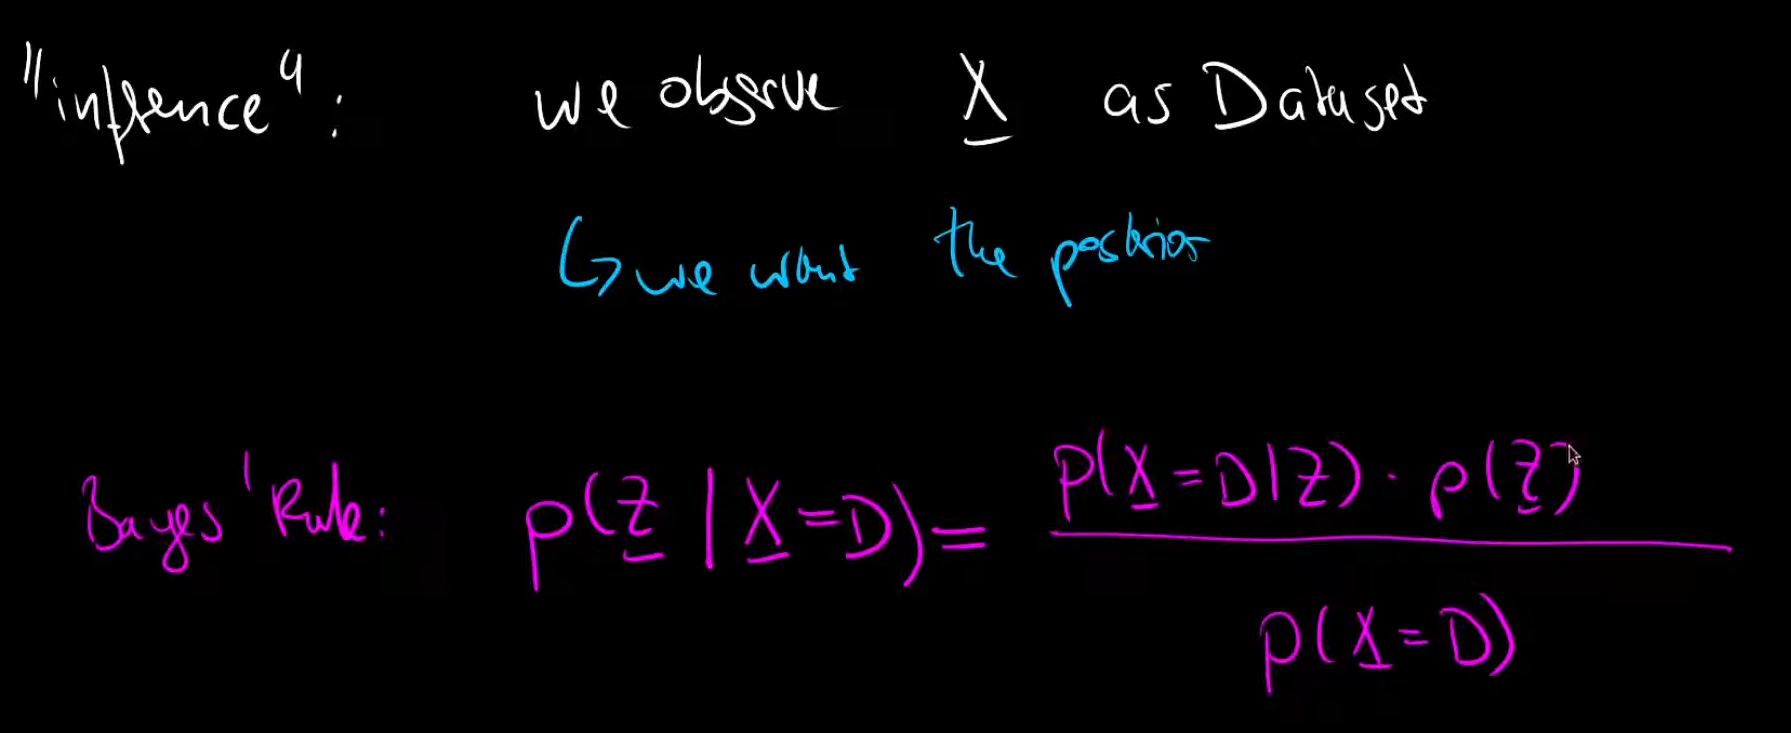




El problema es sacar la marginal de $X=D$, se pierden las variables de normalizacion.


La probabilidad de X va a ser la integral D dimensional sobre cada una de las variables latentes de $Z$.


La a posteriori puede ser en lugar de hayar $q(z) ≈ p(z|X=D)$ lo mejor que se pueda. Lo variacional viene sobre optimizar por una funcion, entonces para optimizar necesitamos una metrica para decir que estamos cerca con nuestra propuesta. Mido la distancia entre $q$ y $P$.


La metrica la vemos como la divergencia de $KL$ (distancia entre dos distribuciones). Cuando es minima, son mas parecidas las distribuciones entre si. (cero serian la misma distribucion).


$$q^*(z) = arg_{min} ( KL ( q(Z) || p(z|X=D)))$$



La divergencia de Kullback Leiber va aser
$$E_{Z ∼ q(Z)} \frac{log( q(z) )}{p(z|D)}$$


Pero no tenemos la a posteriori, tenemos la conjunta $P(Z,X=D)$, y tampoco la marginal.


Si se le saca la divergencia de la KL a q y la a posteriori $Γ(Z,X=D)$


Despues, si se expresa la a posteriori como la conjunta dividida la probabilidad de $P(X=D)$ y se reemplaza en la divergencia de KL.


Se separa una integral sober Z porque $P(X=D)$ no depende de Z y se separa de la siguiente manera.


Tenemos acceso a la surrogate (la que proponemos), y a la conjunta y tambien a los datos. Tneemos dos esperanza, como los datos no dependen de Z, es directamente la cantidad.

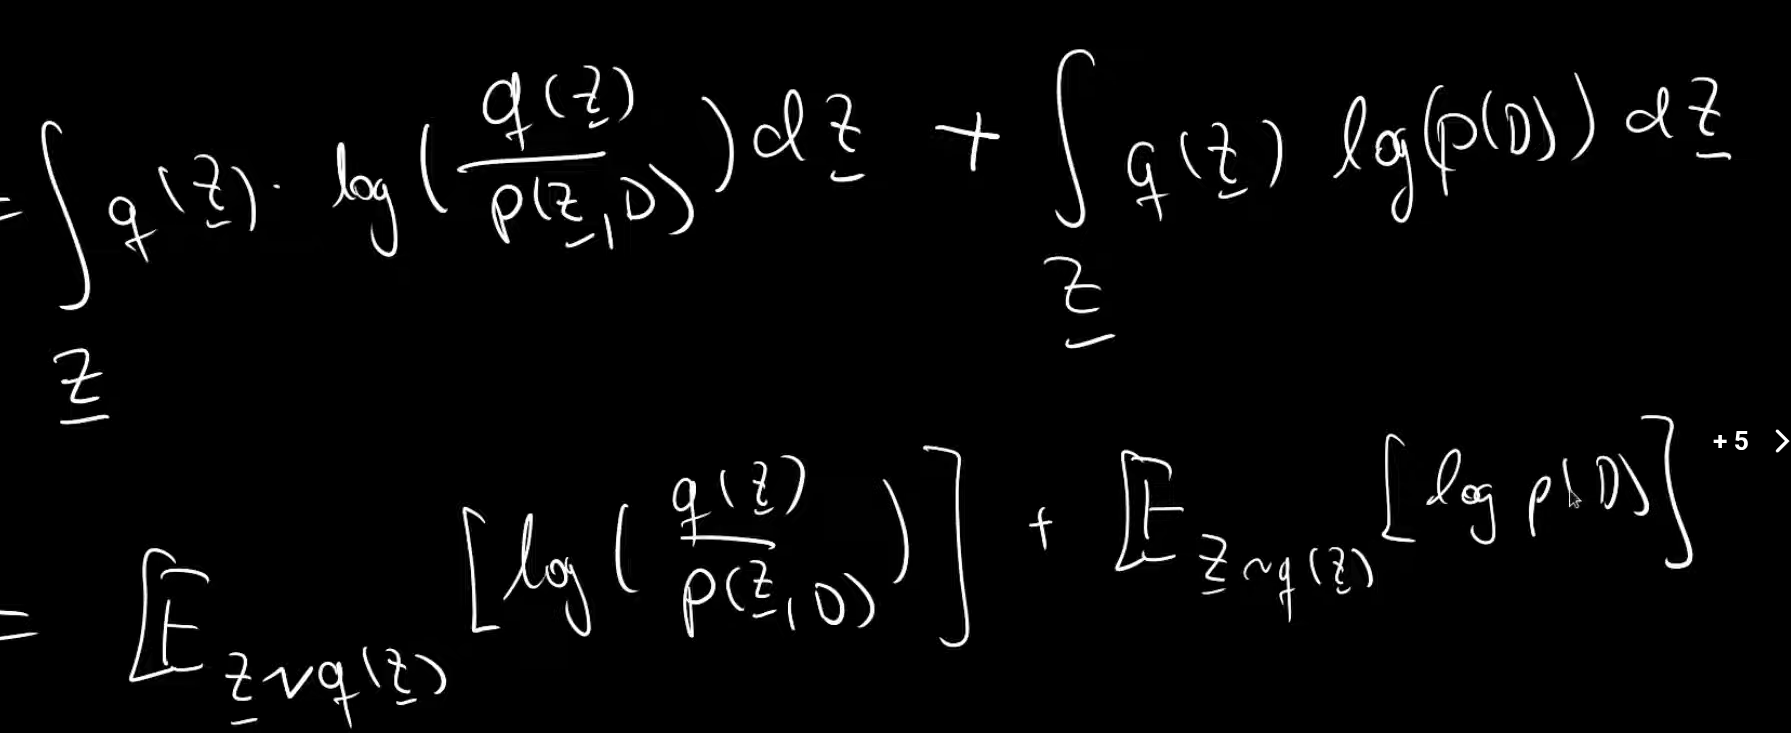

Tenemos que la marginal de los datos esta entre 0 y 1, cuando le aplico el logaritmo devuelve un valor negativo. Es un valor fijo.
La KL es una distancia que tiene que ser positiva, por lo tanto la esperanza del logaritmo tiene que ser negativo. El hecho de que tenga que ser negativo, esperamos que sea menor que la marginal de X. $L(q)$ < $log(p(D))$. Evidence lower bound -> ELBO.




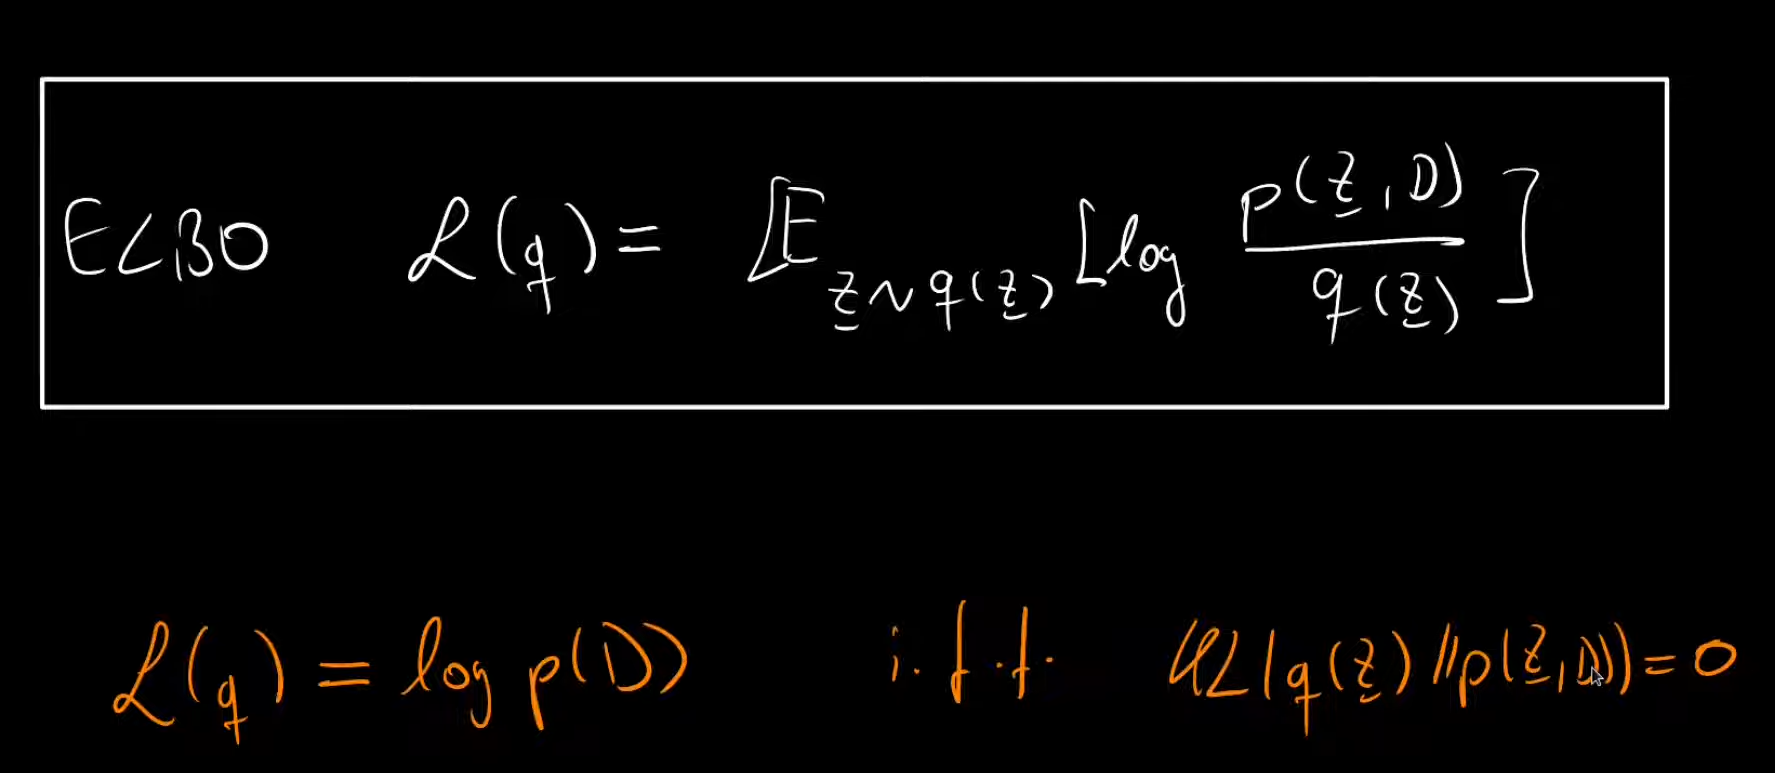

La tarea ahora de variational inference es conseguir $q*(Z) = arg_min(KL(q(z)|P(Z,D))$.


Pero es lo mismo decir que es el maximo sobre el evidence lower bound. Si es igual a la evidencia encontramos la true posterior (igual, en general no se puede).




###**Parte teorica correspondiente al apunte**
Para mezcla de Gaussianas escalares en BV se interpreta la red bayesiana de la siguiente forma.


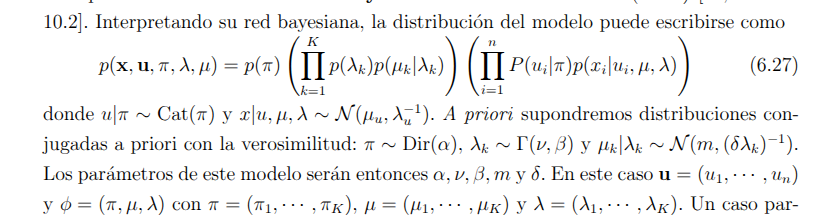

La distribucion a posteriori es una gamma y la predictiva es una t student.
Usar la a priori una media gaussiana y inversa de varianza gamma (precision) tiene nombre de distribucion normal gamma.


Usando mean field approximation, se supone que q se puede factorizar entre variables ocultas u y los parametros $\phi$.

La distribucion $q_2(\pi | X)$ es una dirichlett, donde el paraemtro alpha se calcula como $$\alpha_k^* = \alpha_k + N_k$$

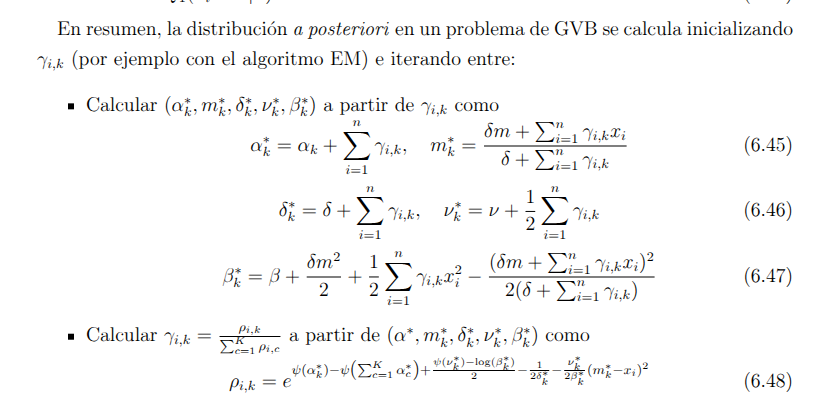

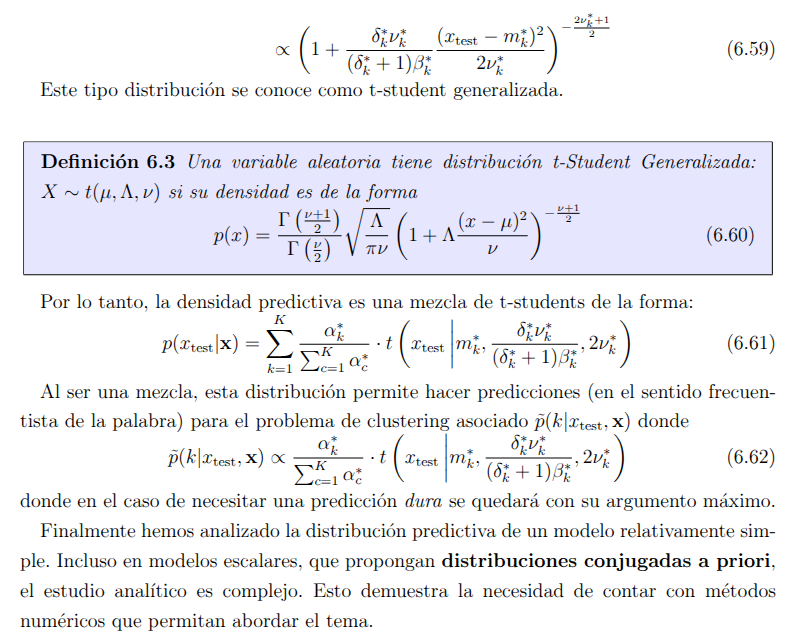

Basicamente lo que estoy haciendo es usando la mean field approximation separando las variables del problema.
Sabiendo que parto de Gaussianas, hago primero la actualizacion de los parametros a posteriori (asumiendo que las familias elegidas con conjugadas a priori con parametros $\alpha , \nu,  \beta, m, \delta $. Como el logaritmo de la normal es cuadratica en las muestras defino estadisticos suficientes.
La distribucion de la actualizacion de estos parametros es Normal Gamma. A partir de los estadisticos suficientes antes calculados se calculan las actualizaciones en los parametros a posteriori de la gamma.


Despues, para la actualizacion de la distribuion de las variables ocultas , mediante propiedades de la Gamma y la Beta, se nota la independencia de las variables ocultas con respecto a la tira de valores. Luego, se hace la actualizacion de la distribucion de las variables ocultas y asi hasta la convergencia. Despues, como se vio en clase, la distribucion predictiva es una t student generalizada.

#Variational Bayes para Mezclas Gaussianas: Resumen del Procedimiento

El método aplicado se basa en una **aproximación Mean–Field**, donde el posterior completo se factoriza en distribuciones más simples e independientes entre sí. Para un modelo de mezcla Gaussiana, esta aproximación permite separar los parámetros del modelo y las variables latentes de asignación.

---

## 1. Selección de familias variacionales conjugadas

Dado que partimos de componentes Gaussianos con parámetros desconocidos, elegimos priors conjugados para facilitar la inferencia:

- Para los pesos de mezcla:
  $$ \pi \sim \mathrm{Dirichlet}(\alpha_0) $$

- Para cada par de parámetros del componente:
  $$ (\mu_k,\tau_k) \sim \mathrm{NormalGamma}(m_0,\beta_0,a_0,b_0) $$

Bajo la aproximación Mean–Field, el posterior se factoriza como:

$$
q(\pi)\, q(\mu,\tau)\, \prod_{n=1}^N q(z_n),
$$

donde $z_n$ son las variables latentes de asignación.

---

## 2. Estadísticos suficientes y forma cuadrática de la Gaussiana

El logaritmo de la densidad Normal es cuadrático en los datos, por lo que los términos relevantes pueden resumirse mediante **estadísticos suficientes**:

- suma de las probabilidades de que cada muestra pertenezca a la clase $k$:
  $$
  N_k = \sum_{n=1}^N r_{nk}
  $$

- media ponderada según esas probabilidades:
  $$
  \bar{x}_k = \frac{1}{N_k} \sum_{n=1}^N r_{nk} \, x_n
  $$

- dispersión dentro de la clase según esas probabilidades:
  $$
  S_k = \sum_{n=1}^N r_{nk} (x_n - \bar{x}_k)^2
  $$

Estos resúmenes permiten actualizar los parámetros variacionales sin necesidad de tratar cada dato por separado.

---

## 3. Actualización de los parámetros a posteriori (Normal–Gamma)

Usando la forma funcional de la distribución Normal–Gamma y los estadísticos suficientes, se obtienen directamente las **actualizaciones variacionales**:

- $ \beta_k = \beta_0 + N_k $
- $ m_k = \frac{\beta_0 m_0 + N_k \bar{x}_k}{\beta_k} $
- $ a_k = a_0 + \tfrac{1}{2} N_k $
- $ b_k = b_0 + \tfrac{1}{2} S_k + \frac{1}{2} \frac{\beta_0 N_k}{\beta_0 + N_k} (\bar{x}_k - m_0)^2 $

Estas ecuaciones provienen de combinar el prior conjugado con los estadísticos suficientes basados en la **probabilidad de cada muestra de pertenecer a cada una de las clases**.

---

## 4. Actualización de las variables ocultas

Una vez actualizados los parámetros del posterior, se procede a actualizar las distribuciones $q(z_n)$ asociadas a las clases.

Cada $r_{nk}$ representa **la probabilidad de que la muestra $x_n$ pertenezca a la clase $k$** bajo la aproximación variacional:

$$
q(z_n = k) = r_{nk}.
$$

Usando las propiedades de la Dirichlet (para $\pi$) y la Gamma (para $\tau_k$), se obtiene:

$$
\log r_{nk} =
\mathbb{E}[\log \pi_k]
+ \frac{1}{2}\mathbb{E}[\log\tau_k]
- \frac{1}{2} \log(2\pi)
- \frac{1}{2}\mathbb{E}[\tau_k]
\Big[ (x_n - m_k)^2 + \frac{1}{\beta_k} \Big].
$$

Finalmente, los valores $r_{nk}$ se normalizan con un softmax para que formen una distribución válida sobre las clases.

El procedimiento alterna entre:

1. actualizar los parámetros del posterior,  
2. actualizar las probabilidades de pertenencia de cada muestra a cada clase,

hasta que la ELBO converge.

Despues, se puede demostrar que la distribucion predictiva es una t-Student generalizada.


---

## Conclusión

El procedimiento completo alterna entre:

1. **inferir las distribuciones variacionales sobre los parámetros** usando los estadísticos suficientes,  
2. **actualizar las probabilidades de pertenencia de cada muestra a cada una de las clases**,  
3. hasta que la ELBO deja de mejorar.

La combinación de **conjugación** y **Mean–Field** permite derivar todas las actualizaciones en forma analítica y obtener, además, una distribución predictiva exacta en forma de t-Student Generalizada.


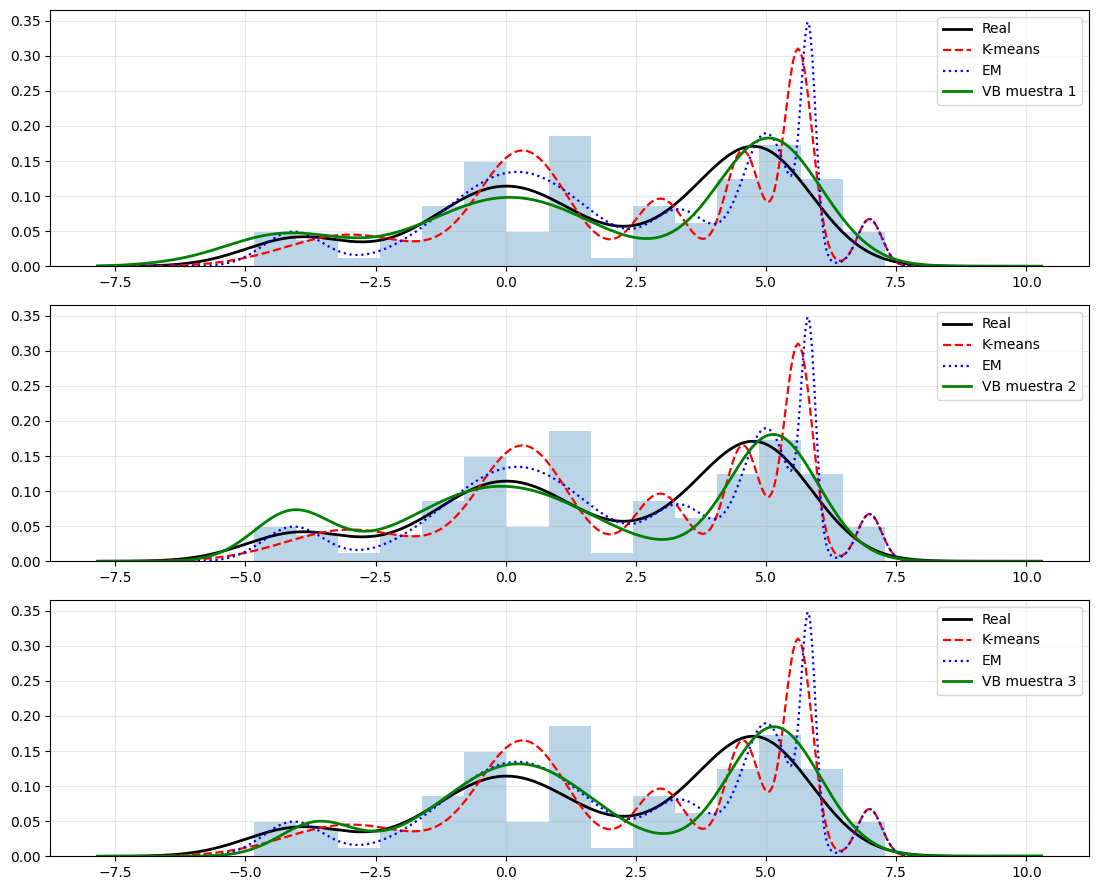

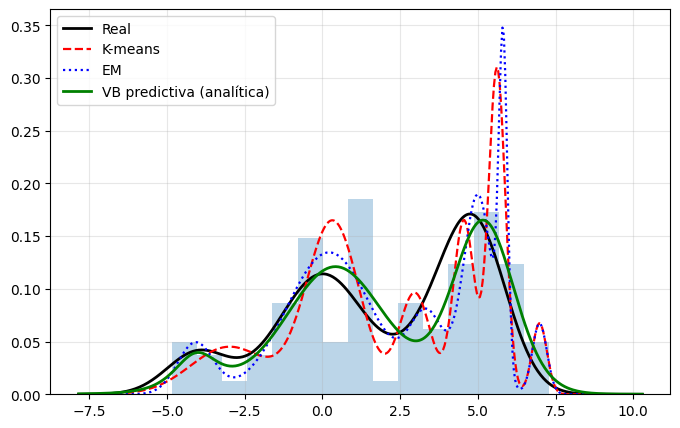

In [54]:
# ==========================================================
#               VARIATIONAL BAYES GAUSSIANO
# ==========================================================
class GaussianVB:
    def __init__(self, K, m0=0.0, beta0=0.05, a0=0.05, b0=0.05,
                 alpha0=None, max_iter=500, tol=1e-3):
        self.K = K
        self.m0 = float(m0)
        self.beta0 = float(beta0)
        self.a0 = float(a0)
        self.b0 = float(b0)
        self.alpha0 = np.ones(K) if alpha0 is None else np.array(alpha0)
        self.max_iter = max_iter
        self.tol = tol

    def E_log_pi(self, alpha):
        return digamma(alpha) - digamma(np.sum(alpha))

    def E_tau(self, a, b):
        return a / b

    def E_log_tau(self, a, b):
        return digamma(a) - np.log(b)

    # ==========================================================
    #                           FIT
    # ==========================================================
    def fit(self, X, r_init):
        X = X.reshape(-1)
        N = len(X)
        K = self.K

        r = r_init.copy()
        Nk = r.sum(axis=0) + 1e-12
        xbar = (r.T @ X) / Nk

        # ---- Inicialización VB ----
        alpha = self.alpha0 + Nk
        beta = self.beta0 + Nk
        m = (self.beta0*self.m0 + Nk*xbar) / beta
        a = self.a0 + 0.5*Nk

        S = np.array([np.sum(r[:,k]*(X - xbar[k])**2) for k in range(K)])
        b = self.b0 + 0.5*S + 0.5*(self.beta0*Nk/(self.beta0+Nk))*(xbar - self.m0)**2

        elbo_trace = []

        # ==========================================================
        #                      ITERACIONES VB
        # ==========================================================
        for it in range(self.max_iter):

            # ----- E-step -----
            Elogpi = self.E_log_pi(alpha)
            Etau = self.E_tau(a,b)
            Elogtau = self.E_log_tau(a,b)

            log_r = np.zeros((N,K))
            for k in range(K):
                quad = (X - m[k])**2 + 1/beta[k]
                log_r[:,k] = Elogpi[k] + 0.5*Elogtau[k] - 0.5*np.log(2*np.pi) - 0.5*Etau[k]*quad

            r = softmax(log_r, axis=1)
            Nk = r.sum(axis=0) + 1e-12
            xbar = (r.T @ X) / Nk

            # ----- M-step -----
            alpha = self.alpha0 + Nk
            beta = self.beta0 + Nk
            m = (self.beta0*self.m0 + Nk*xbar) / beta
            a = self.a0 + 0.5*Nk

            S = np.array([np.sum(r[:,k]*(X - xbar[k])**2) for k in range(K)])
            b = self.b0 + 0.5*S + 0.5*(self.beta0*Nk/(self.beta0+Nk))*(xbar - self.m0)**2

            # ---- ELBO reducido ----
            elbo = np.sum(r*Elogpi)
            for k in range(K):
                quad = (X - m[k])**2 + 1/beta[k]
                elbo += 0.5*np.sum(r[:,k]*(Elogtau[k] - np.log(2*np.pi) - Etau[k]*quad))

            elbo_trace.append(elbo)

            if it>0 and abs(elbo_trace[-1]-elbo_trace[-2]) < self.tol:
                break

        # guardo resultados finales
        self.alpha = alpha
        self.beta = beta
        self.m = m
        self.a = a
        self.b = b
        self.resp_ = r
        self.elbo_trace = elbo_trace

        return self

    # ==========================================================
    #                   PREDICT PROBA Y PREDICT
    # ==========================================================
    def predict_proba(self, X):
        X = X.reshape(-1)
        N = len(X)
        K = self.K
        log_r = np.zeros((N,K))

        Elogpi = self.E_log_pi(self.alpha)
        Etau = self.E_tau(self.a,self.b)
        Elogtau = self.E_log_tau(self.a,self.b)

        for k in range(K):
            quad = (X - self.m[k])**2 + 1/self.beta[k]
            log_r[:,k] = Elogpi[k] + 0.5*Elogtau[k] - 0.5*np.log(2*np.pi) - 0.5*Etau[k]*quad

        return softmax(log_r, axis=1)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    # ==========================================================
    #             SAMPLE DE PARÁMETROS POSTERIOR
    # ==========================================================
    def sample_parameters(self):
        pi = np.random.gamma(self.alpha, 1)
        pi /= pi.sum()

        tau = np.random.gamma(self.a, 1/self.b)   # gamma(a, scale=1/b)

        mu = np.array([
            np.random.normal(self.m[k], np.sqrt(1/(self.beta[k]*tau[k])))
            for k in range(self.K)
        ])

        return pi, mu, tau

    # ==========================================================
    #             DENSIDAD T (para la predictiva)
    # ==========================================================
    def t_pdf(self, x, mu, Lambda, nu):
        A = gamma((nu+1)/2) / ( np.sqrt(np.pi*nu) * gamma(nu/2) )
        B = np.sqrt(Lambda)
        C = (1 + (Lambda*(x-mu)**2)/nu ) ** (-(nu+1)/2)
        return A * B * C

    # ==========================================================
    #             PREDICTIVA ANALÍTICA (MEZCLA t)
    # ==========================================================
    def predictive_density(self, X):
        X = X.reshape(-1)
        p = np.zeros_like(X)
        weights = self.alpha / self.alpha.sum()

        for k in range(self.K):
            mu_k = self.m[k]
            nu_k = self.a[k]               # grados de libertad
            delta_k = self.beta[k]             # δ*
            beta_k  = self.b[k]                # β*

            Lambda_k = delta_k * nu_k / ((delta_k + 1) * beta_k)

            p += weights[k] * self.t_pdf(X, mu_k, Lambda_k, nu_k)

        return p

vb = GaussianVB(K=K, m0=0, beta0=0.05, a0=0.05, b0=0.05,
                alpha0=np.ones(K), max_iter=500, tol=1e-6)

vb.fit(x, r_init=em.predict_proba(x))#uso el EM para inicializar las probabilidades


xs = np.linspace(x.min()-3, x.max()+3, len(p_real))

plt.figure(figsize=(11,9))
for i in range(3):
    pi_s, mu_s, tau_s = vb.sample_parameters()
    p_s = pdf_mix(xs, pi_s, mu_s, 1/tau_s)

    plt.subplot(3,1,i+1)
    plt.hist(x, bins=15, density=True, alpha=0.3)
    plt.plot(xs, p_real, 'k', lw=2, label="Real")
    plt.plot(xs, p_kmeans, 'r--', lw=1.6, label="K-means")
    plt.plot(xs, p_em, 'b:', lw=1.6, label="EM")
    plt.plot(xs, p_s, 'g-', lw=2, label=f"VB muestra {i+1}")
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# ==========================================================
#           (2) DENSIDAD PREDICTIVA ANALÍTICA VB
# ==========================================================
p_vb_pred = vb.predictive_density(xs)

plt.figure(figsize=(8,5))
plt.hist(x, bins=15, density=True, alpha=0.3)
plt.plot(xs, p_real, 'k', lw=2, label="Real")
plt.plot(xs, p_kmeans, 'r--', lw=1.6, label="K-means")
plt.plot(xs, p_em, 'b:', lw=1.6, label="EM")
plt.plot(xs, p_vb_pred, 'g-', lw=2, label="VB predictiva (analítica)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


El GVB es el algoritmo que mejor funciona, logra apagar las clases que no tienen que aparecer para encontrar la distribucion, parece ser superior cuando no estoy seguro de la dimensionalidad del problema a plantear. Probe tambien con K=4 y los resultados son similares entre EM y el GVB (logicamente).
Las muestras por separado tienen distribuciones similares entre si, pero dependiendo de la corrida puede dar mejor o peor dado que es aleatorio, pero siempre dentro de un margen razonable.